In [12]:
# --- 1. Imports & setup ---
import os
import sqlite3
from PIL import Image
import imagehash
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# Dossier d'images de référence (une carte par image)
REF_DIR = "reference_images/mega-evolution/fr-fr"  # à adapter à ton chemin
DB_PATH = "cards_hashes.db"
HASH_TYPE = "phash"  # 'phash', 'dhash', 'ahash', 'whash'
HASH_SIZE = 16

In [14]:
# --- 2. Utility functions ---

def compute_hash(pil_img, hash_type="phash", hash_size=16):
    """Calcule un hash perceptuel à partir d'une image PIL."""
    if hash_type == "phash":
        return str(imagehash.phash(pil_img, hash_size=hash_size))
    if hash_type == "dhash":
        return str(imagehash.dhash(pil_img, hash_size=hash_size))
    if hash_type == "ahash":
        return str(imagehash.average_hash(pil_img, hash_size=hash_size))
    if hash_type == "whash":
        return str(imagehash.whash(pil_img, hash_size=hash_size))
    raise ValueError("Type de hash inconnu")

def init_db(path):
    con = sqlite3.connect(path)
    cur = con.cursor()
    cur.execute("""
        CREATE TABLE IF NOT EXISTS cards (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT,
            file_path TEXT,
            hash TEXT
        )
    """)
    con.commit()
    con.close()

In [15]:
# --- 3. Calcul des hashes ---
init_db(DB_PATH)

records = []
files = [f for f in os.listdir(REF_DIR) if f.lower().endswith((".png",".jpg",".jpeg"))]
for fn in tqdm(files, desc="Calcul des hashes"):
    path = os.path.join(REF_DIR, fn)
    try:
        img = Image.open(path).convert("RGB")
        img = img.resize((400, int(400 * img.height / img.width)))
        h = compute_hash(img, HASH_TYPE, HASH_SIZE)
        name = os.path.splitext(fn)[0]
        records.append((name, path, h))
    except Exception as e:
        print(f"Erreur {fn}:", e)

print(f"{len(records)} images traitées.")

Calcul des hashes: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 133.08it/s]

3 images traitées.


In [16]:
# --- 4. Sauvegarde dans DB & DataFrame ---
con = sqlite3.connect(DB_PATH)
cur = con.cursor()
for name, path, h in records:
    cur.execute("INSERT INTO cards (name, file_path, hash) VALUES (?, ?, ?)", (name, path, h))
con.commit()
con.close()

df = pd.DataFrame(records, columns=["name", "file_path", "hash"])
df.head()

,name,file_path,hash
0,JL2G_FR_1,reference_images/mega-evolution/fr-fr\JL2G_FR_...,e1be69be541190d31aee36742ff987098fa02fa7c127cc...
1,JL2G_FR_2,reference_images/mega-evolution/fr-fr\JL2G_FR_...,aeb97ab8d004814f9f1a0f180ef0cce7d8e335e327a7e7...
2,JL2G_FR_3,reference_images/mega-evolution/fr-fr\JL2G_FR_...,88d01ebe4008e94d67ca34ed36a5ce340b7241535d737d...


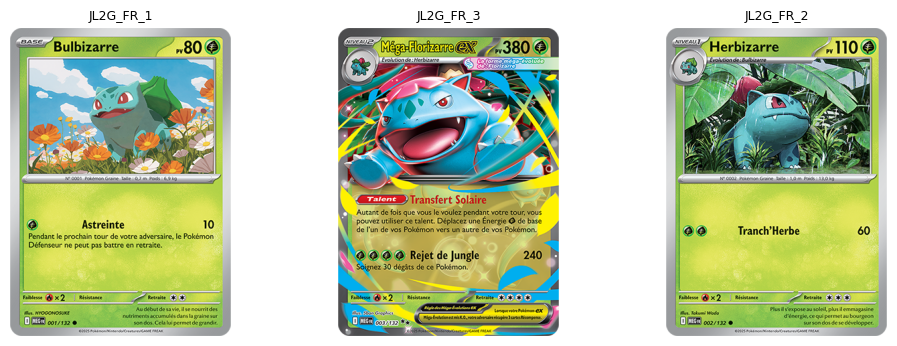

,name,file_path,hash
0,JL2G_FR_1,reference_images/mega-evolution/fr-fr\JL2G_FR_...,e1be69be541190d31aee36742ff987098fa02fa7c127cc...
2,JL2G_FR_3,reference_images/mega-evolution/fr-fr\JL2G_FR_...,88d01ebe4008e94d67ca34ed36a5ce340b7241535d737d...
1,JL2G_FR_2,reference_images/mega-evolution/fr-fr\JL2G_FR_...,aeb97ab8d004814f9f1a0f180ef0cce7d8e335e327a7e7...


In [17]:
# --- 5. Affichage échantillon ---
n = min(6, len(df))
sample = df.sample(n)

plt.figure(figsize=(12, 4))
for i, (_, row) in enumerate(sample.iterrows()):
    img = Image.open(row.file_path)
    plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.title(row["name"], fontsize=9)
    plt.axis("off")
plt.show()

sample

In [18]:
query_img = Image.open("test_images/test1.jpg").convert("RGB").resize((400, 300))
query_hash = compute_hash(query_img, HASH_TYPE, HASH_SIZE)

# Comparer au plus proche
con = sqlite3.connect(DB_PATH)
df_db = pd.read_sql("SELECT * FROM cards", con)
con.close()

df_db["distance"] = df_db["hash"].apply(lambda h: imagehash.hex_to_hash(h) - imagehash.hex_to_hash(query_hash))
df_db.sort_values("distance").head(5)

,id,name,file_path,hash,distance
2,3,JL2G_FR_2,reference_images/mega-evolution/fr-fr\JL2G_FR_...,aeb97ab8d004814f9f1a0f180ef0cce7d8e335e327a7e7...,120
0,1,JL2G_FR_1,reference_images/mega-evolution/fr-fr\JL2G_FR_...,e1be69be541190d31aee36742ff987098fa02fa7c127cc...,124
1,2,JL2G_FR_1,reference_images/mega-evolution/fr-fr\JL2G_FR_...,e1be69be541190d31aee36742ff987098fa02fa7c127cc...,124
3,4,JL2G_FR_3,reference_images/mega-evolution/fr-fr\JL2G_FR_...,88d01ebe4008e94d67ca34ed36a5ce340b7241535d737d...,134
